In [ ]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [ ]:
import sys

import matplotlib.pyplot as plt

sys.path.append('../scripts')
sys.path.append('../')

from heapq import heappop, heappush
from itertools import count

import time
from multiprocessing import Pool
from time import sleep

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import centroids_graph_builder, graph_osm_loader, utils, clustering

import networkx as nx


In [ ]:
def dijkstra_pfa_min_dst(graph: nx.Graph,
                 start: set[int],
                 ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []
    for s in start:
        dist[s] = 0.0
        push(fringe, (0.0, next(c), s))
    while fringe:
        (d, _, v) = pop(fringe)
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u] > vu_dist:
                dist[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
    return dist


In [ ]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in range(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [96]:
GRAPH_ID = 'R2555133'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 100000
p = 3/N
# g = get_rand_grAaph(N,p)
# g = get_graph()
g= graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

17923 27016


In [97]:
g.remove_edges_from(nx.selfloop_edges(g))

In [98]:
np.sqrt(len(g.nodes))

133.87680904473336

In [99]:
cms = clustering.resolve_k_means_communities(g, resolution=500, max_iteration=100, print_log=True)

2024-11-26 11:25:40,409 - root - INFO - communities: 3430


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


In [140]:
d_clusters = np.zeros((len(cms), len(cms)),dtype=np.float32)
d_clusters.size * d_clusters.itemsize / 1024 / 1024

44.87953186035156

In [101]:



def calc(data):
    points, name, cms, g = data 
    d_clusters = np.zeros((len(cms), len(cms)))

    for u in points:
        ll = dijkstra_pfa_min_dst(g, cms[u])
        q = {}
        for v, d in ll.items():
            if g.nodes()[v][name] in q:
                q[g.nodes()[v][name]] = min(q[g.nodes()[v][name]], d)
            else:
                q[g.nodes()[v][name]] = d
        for v in range(len(cms)):
            if v in q:
                d_clusters[u, v] = q[v]
    return d_clusters

In [102]:
w = 4

In [103]:
cms_points = list(range(len(cms)))
data = [(cms_points[i::w],'cluster', cms, g) for i in range(w)]

In [104]:
with Pool(w) as p:
    d_clusters = sum(tqdm(p.imap_unordered(calc, data), total = len(data)))

  0%|          | 0/4 [00:00<?, ?it/s]

In [105]:
nodes = g.nodes()

In [106]:
def func(u, v):
    n1,n2 = nodes[u],nodes[v]
    c11 = n1['cluster']
    c12 = n2['cluster']  
    return d_clusters[c11, c12]

In [135]:
def dijkstra_pfa_cls(graph: nx.Graph,
                     start: int,
                     end: int
                     ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    push = heappush
    pop = heappop
    dist = {start: (0, None)}
    fringe = []
    c = count()
    adjacency = graph._adj
    push(fringe, (0, next(c), 0, func(start, end), start))

    while fringe:
        (_, _, d1, l1, v1) = pop(fringe) 
        if v1 == end:
            break
        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                dist[u] = (vu_dist, v1)
                lu = func(u, end)
                push(fringe, (vu_dist + lu, next(c), vu_dist, lu, u))
    path = [end]
    e = end
    while dist[e][1] is not None:
        e = dist[e][1]
        path.append(e)
    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path.reverse()

In [128]:
def bi_dijkstra_pfa_cls(graph: nx.Graph,
                        start: int,
                        end: int
                        ) -> tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    
    push = heappush
    pop = heappop
    dist = ({start: (0, None)}, {end: (0, None)})
    fringe = ([], [])
    c = count()
    adjacency = graph._adj

    push(fringe[0], (0, next(c), 0,  start))
    push(fringe[1], (0, next(c), 0,  end))
    
    union_node = None
    union_dst = float('inf')
    seen = (set(), set())
    while fringe[0] and fringe[1]:
        (_, _, d1,  v1) = pop(fringe[0])
        (_, _, d2,  v2) = pop(fringe[1])

        for u, e in adjacency[v1].items():
            vu_dist = d1 + e['length']
            if u not in dist[0] or dist[0][u][0] > vu_dist:
                dist[0][u] = (vu_dist, v1)
                lu = func(u,end)
                push(fringe[0], (vu_dist + lu, next(c), vu_dist, u))
        for u, e in adjacency[v2].items():
            vu_dist = d2 + e['length']
            if u not in dist[1] or dist[1][u][0] > vu_dist:
                dist[1][u] = (vu_dist, v2)
                lu = func(u,start)
                push(fringe[1], (vu_dist + lu, next(c), vu_dist, u))
        if v1 in seen[1]:
            union_node = v1
            union_dst = dist[0][v1][0] + dist[1][v1][0]
            break
        if v2 in seen[0]:
            union_node = v2
            union_dst = dist[0][v2][0] + dist[1][v2][0]
            break
        seen[0].add(v1)
        seen[1].add(v2)
        
    for (_, _, d1, v1) in fringe[0]:
        if v1 in dist[1]:
            dd = dist[1][v1][0] + dist[0][v1][0]
            if dd < union_dst:
                union_dst = dd
                union_node = v1
        for u, e in adjacency[v1].items():
            if u in dist[1]:
                if u not in dist[0]:
                    vu_dist = d1 + e['length']
                    dist[0][u] = (vu_dist, v1)    
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
                    
    for (_, _, d2, v2) in  fringe[1]:
        if v2 in dist[0]:
            dd = dist[1][v2][0] + dist[0][v2][0]
            if dd < union_dst:
                union_dst = dd
                union_node = v2
        for u, e in adjacency[v2].items():
            if u in dist[0]:
                if u not in dist[1]:
                    vu_dist = d2 + e['length']
                    dist[1][u] = (vu_dist, v2)
                dd = dist[1][u][0] + dist[0][u][0]
                if dd < union_dst:
                    union_dst = dd
                    union_node = u
    path = []
    e = union_node
    while dist[0][e][1] is not None:
        path = [e] + path
        e = dist[0][e][1]
    path = [e] + path

    e = union_node
    while dist[1][e][1] is not None:
        e = dist[1][e][1]
        path += [e]

    l = 0
    e = g.edges()
    for i in range(len(path) - 1):
        p1, p2 = path[i], path[i + 1]
        l += e[p1, p2]['length']
    return l, path

In [129]:
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

generate points:   0%|          | 0/1000 [00:00<?, ?it/s]

In [136]:
NUM_ITERATION = 3  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 4  # количество потоков


def do_calc(data):
    pps, i = data

    stat = {}
    stat['l'] = []
    stat['h_l'] = []

    stat['p'] = []
    stat['h_p'] = []
    stat['time_l'] = []
    stat['time_h'] = []

    stat['delta'] = []
    # чисто чтобы tqdm нормально прогрузился 
    sleep(i / 10)
    print('start', i)

    for p1, p2 in tqdm(pps, desc='find paths', position=i):
        if (p1, p2) in stat:
            continue
        # класический дейкстра
        l, p = None, None
        start = time.time()
        for i in range(NUM_ITERATION):
            l, p = nx.single_source_dijkstra(g, p1, p2, weight='length')
        time_l = time.time() - start

        # иерархический
        h_l, h_p = None, None
        start = time.time()
        for _ in range(NUM_ITERATION):
            h_l, h_p = dijkstra_pfa_cls(g, p1, p2) 
        time_h = time.time() - start

        delta = (h_l - l) / l * 100
        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
    return stat

data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
# do_calc(data[0])
with Pool(WORKER) as p:
    res = p.map(do_calc, data)

stat = {}
for l in res:
    for d in l:
        if d not in stat:
            stat[d] = []
        stat[d].extend(l[d])
print(f"err_mean: {np.mean(stat['delta']):.2f} %")
print(f"err_min: {np.min(stat['delta']):.2f} %")
print(f"err_max: {np.max(stat['delta']):.2f} %", )
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")

start 0


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

err_mean: -0.00 %
err_min: -0.00 %
err_max: 0.00 %
acceleration: 36.64 times


In [131]:
max_err_idx = np.argmax(stat['delta'])


In [132]:
path = stat['p'][max_err_idx]
h_path = stat['h_p'][max_err_idx]

In [73]:
path

[5304076496,
 1593709369,
 1869548043,
 2028570543,
 2028570465,
 2028570395,
 2028570225,
 1521196305,
 1521196292,
 1521196276,
 1526038975,
 1526038964,
 620100728,
 2027953685,
 1289849080,
 5301648306,
 1289849110,
 620101502]

In [74]:
h_path

[5304076496,
 1593709369,
 1869548043,
 2027953813,
 1526038988,
 1526038986,
 2027953779,
 1521196275,
 1526038972,
 1526038964,
 620100728,
 2027953685,
 1289849080,
 5301648306,
 1289849110,
 620101502]

In [75]:
len(path), len(h_path)

(18, 16)

In [76]:
print(np.array(path) - np.array(h_path))

ValueError: operands could not be broadcast together with shapes (18,) (16,) 

In [134]:
stat['l'][max_err_idx], stat['h_l'][max_err_idx]

(4084.9719999999993, 4289.187)

In [78]:
p1, p2 = path[0], path[-1]

In [79]:
labels = {u: d['cluster'] for u, d in g.nodes(data=True)}

In [116]:
pos_l = {u: [d['x'] + 0.001, d['y'] + 0.001] for u, d in g.nodes(data=True)}
pos = {u: [d['x'], d['y']] for u, d in g.nodes(data=True)}


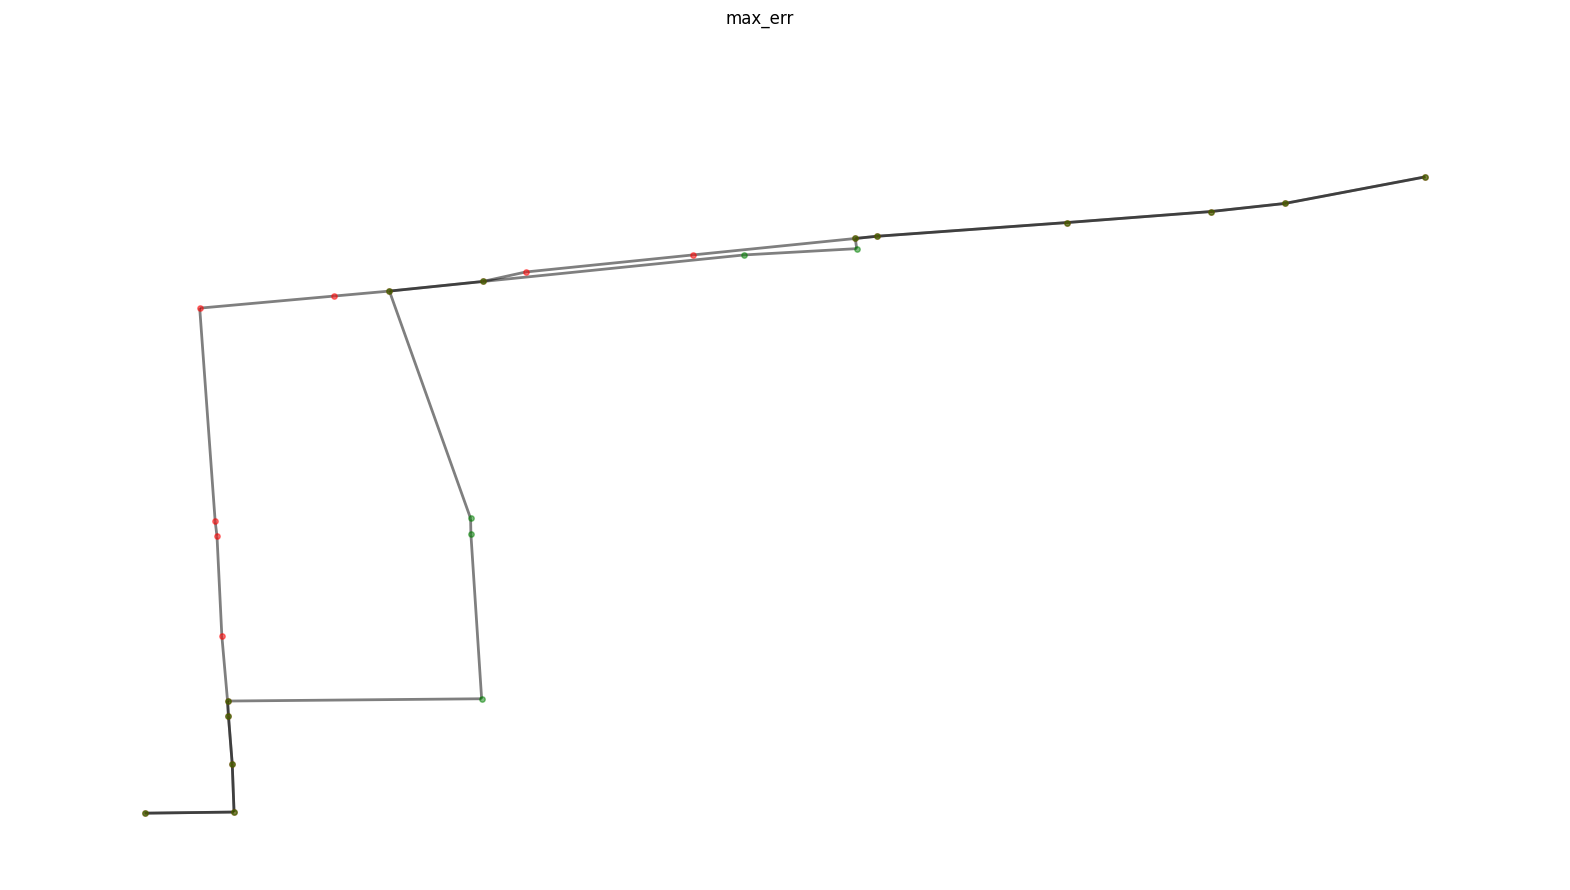

In [133]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
f.suptitle('max_err')


# nx.draw(g, pos=pos, ax=ax, node_size=10, alpha=0.5)
nx.draw(g.subgraph(path), pos=pos, ax=ax, node_size=15, node_color='red', width=2, alpha=0.5)
nx.draw(g.subgraph(h_path), pos=pos, ax=ax, node_size=15, node_color='green', width=2, alpha=0.5)
# nx.draw_networkx_labels(g,pos_l,labels=labels,font_size=6)

In [ ]:
nx.single_source_dijkstra(g,p1,p2,weight='length')

In [ ]:
bi_dijkstra_pfa_cls(g, p1,p2)

In [ ]:
893305603 in nx.single_source_dijkstra(g,p1,p2,weight='length')[1]